Описание задачи https://boosters.pro/championship/rekko_challenge/data

Статья на хабре https://habr.com/ru/company/okko/blog/454224/


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! pip install lightfm
! pip install implicit

! pip install -U scikit-learn==0.21.3

# #Step 0: Change Colab runtime type to GPU
# #Step 1: Download the source code, it will create LightGBM directory on your Colab instance:
# !git clone --recursive https://github.com/Microsoft/LightGBM
# #Step 2: Move the context to LightGBM directory
# %cd /content/LightGBM
# #Step 3: Create build directory under LightGBM (Installation notes also mentioned about going inside the build directory but that will not help in next step, so skipping it)
# !mkdir build
# #Step 4: Install cmake with GPU option and nproc:
# !cmake -DUSE_GPU=1 #avoid ..
# !make -j$(nproc)
# #Step 5: Get python-pip
# !sudo apt-get -y install python-pip
# #Step 6: Install required packages (Here include all packages that you need e.g. if you dont mention pandas then it can give errors later):
# !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
# #Step 7: Move context to python-package:
# %cd /content/LightGBM/python-package
# #Step 8: Compile
# !sudo python setup.py install --precompile

     |████████████████████████████████| 307kB 3.5MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707619 sha256=c572df19ebc92ed4b6f8a7a344f3833d3d8f121e2add3b3d3aa9a702e5681359
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm
     |████████████████████████████████| 1.1MB 3.5MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3471241 sha256=853245058be1834f321fbc6f010052550737afaa2e1bd738692f66cc99a05d62
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit
     |████████████████████████████████| 6.7MB 3.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [0]:
import os
import json
import pandas as pd
import numpy as np
from scipy import stats

from tqdm.notebook import tqdm
import scipy.sparse as sp
from pprint import pprint
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from itertools import product, permutations
import multiprocessing
from sklearn.externals import joblib

from lightfm import LightFM
from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender
import lightgbm as lgb

import seaborn as sns
from matplotlib import pylab as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Загрузка данных

In [0]:
DATA_PATH = '/content/drive/My Drive/Projects/Competitions/rekko_challenge_rekko_challenge_2019/data'

In [0]:
%%time

# данные о фильмах и сериалах
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = pd.DataFrame(json.load(f)).T.reset_index().rename(columns={'index': 'element_uid'})
catalogue['element_uid'] = catalogue['element_uid'].astype(int)

# пользователи, по которым нужно сделать прогнозы
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

# транзакции
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

# рейтинги, оставленные пользователями
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

# сведения о добавлении фильма в закладки
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

CPU times: user 6.01 s, sys: 466 ms, total: 6.47 s
Wall time: 9.91 s


# EDA

Описание данных

`catalogue.json` содержит анонимизированную метаинформацию о доступных в сервисе фильмах и сериалах.

 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

`test_users.json` содержит список пользователей, для которых необходимо построить предсказание

`transactions.csv` — список всех транзакций за определённый период времени

Часть контента никто не смотрел никогда

 - `element_uid` — идентификатор элемента
 - `user_uid` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

`ratings.csv` содержит информацию о поставленных пользователями оценках

 - `rating` — поставленный пользователем рейтинг (от `0` до `10`)

`bookmarks.csv` содержит информацию об элементах, добавленных пользователями в список «Избранное»

In [0]:
print('Количество единиц контента:', catalogue.shape[0])

Количество единиц контента: 10200


In [0]:
transactions[['element_uid','user_uid']].nunique()

element_uid      8296
user_uid       499663
dtype: int64

In [0]:
user_cnt = transactions['user_uid'].nunique()
watched_cnt = transactions.groupby('element_uid').size().to_frame('cnt')
watched_cnt['cnt_proc'] = 100 * watched_cnt['cnt'] / user_cnt

In [0]:
watched_cnt.describe().T

,count,mean,std,min,25%,50%,75%,max
cnt,8296.0,1162.368852,3594.613450,1.0000,39.000000,179.000000,753.000000,68320.000000
cnt_proc,8296.0,0.232631,0.719408,0.0002,0.007805,0.035824,0.150702,13.673216


In [0]:
np.histogram(watched_cnt['cnt'], 5)

(array([8172,   93,   16,   11,    4]),
 array([1.00000e+00, 1.36648e+04, 2.73286e+04, 4.09924e+04, 5.46562e+04,
        6.83200e+04]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


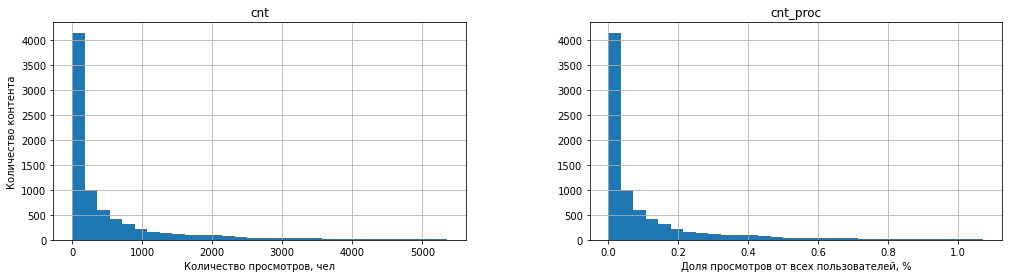

In [0]:
fig, ax = plt.subplots(figsize=(17, 4))
plt.xlabel("Reconstruction error")
plt.xlabel("Data point index")
ax = watched_cnt[watched_cnt < watched_cnt.quantile(0.95)].hist(bins=30, figsize=(17, 4), ax=ax)
ax[0][0].set_xlabel('Количество просмотров, чел')
ax[0][1].set_xlabel('Доля просмотров от всех пользователей, %')
ax[0][0].set_ylabel('Количество контента')
plt.show()

**Следует убрать из списка рекомендаций те фильмы, которые посмотрело менее 0.1% пользователей**

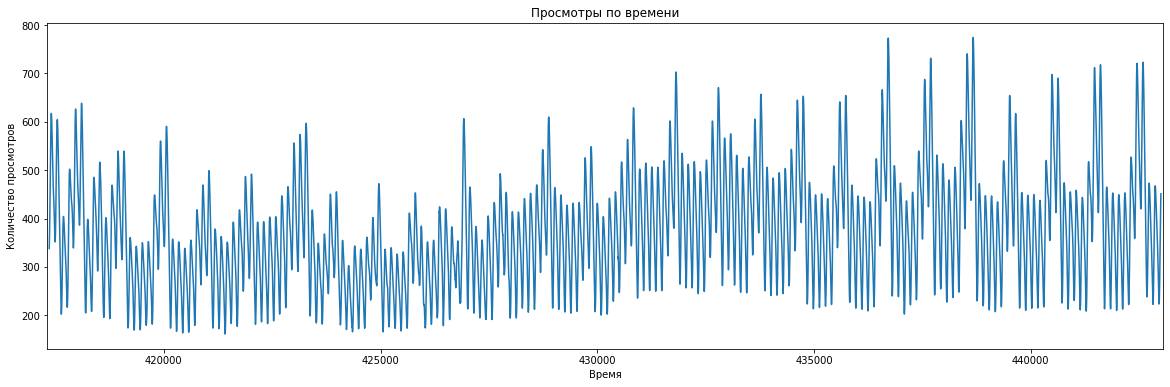

In [0]:
transactions['ts_large'] = (transactions['ts'] / 100).round()
transactions.groupby('ts_large').size().rolling(100, center=True).mean().plot(figsize=(20, 6), title='Просмотры по времени')
plt.ylabel('Количество просмотров')
plt.xlabel('Время')
plt.show()

transactions.drop('ts_large', axis=1, inplace=True)

В получившимся графике отчетливо прослеживаются выходные дни. В эти дни число просмотров больше, чем в будни.
В тестовом датасете данные за 60 дней. По имеющимся данным возможно примерно оценить, какую часть выборки нужно отложить, чтобы сохранить пропорции между train и test.

В предоставленной выборке всего около 28 недель или 196 дней.
60 дней от этой выборки - это около 30%.

**Значит для теста оставим 30% выборки**


У каждого фильма есть набор закодированных атрибутов в виде списка. Для предварительного анализа будем использовать только топ из них

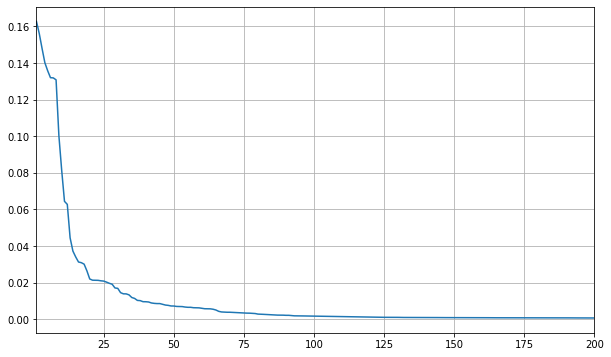

In [0]:
counts_attributes = Counter(np.hstack(catalogue['attributes'].values))
top_attributes = pd.DataFrame(counts_attributes.most_common(), 
                              columns=['attribute', 'n'], 
                              index=range(1, len(counts_attributes)+1))
top_attributes['n'] = top_attributes['n'] / len(counts_attributes)
top_attributes.loc[:200, 'n'].plot(figsize=(10, 6), grid=True);

**Возьмем топ 150 атрибутов**

In [0]:
# пользователи, по просмотрам сериалов

In [0]:
# добавим к транзакциям инфу о самих объектах и рейтингах пользователей
bookmarks['add_bookmark'] = 1
transactions_ext = (transactions.merge(catalogue, on=['element_uid'])
                                .merge(ratings, on=['element_uid', 'user_uid'], how='left', suffixes=['', '_rating'])
                                .merge(bookmarks, on=['element_uid', 'user_uid'], how='left', suffixes=['', '_bookmarks'])
                                .fillna(value={'add_bookmark': 0})
                                )
transactions_ext = transactions_ext.join(pd.get_dummies(transactions_ext['type']))

# добавим медианные рейтинги
ratings_element = ratings.groupby('element_uid')['rating'].median().to_frame('rating_median').reset_index()
transactions_ext = transactions_ext.merge(ratings_element, on='element_uid', how='left')
transactions_ext['rating_median_round'] = transactions_ext['rating_median'].round()

In [0]:
# без рейтинга вообще
transactions_ext[transactions_ext['rating_median'].isnull()].groupby(['element_uid', 'type']).size().sort_values(ascending=False)

element_uid  type           
10175        series             2642
7372         multipart_movie    1182
6455         series              870
5015         series              846
3909         series              746
                                ... 
5537         movie                 1
5728         movie                 1
6545         movie                 1
8217         movie                 1
4772         series                1
Length: 1151, dtype: int64

In [0]:
# нулевые продолжительности
(transactions_ext.query('duration == 0')
                .groupby(['element_uid', 'duration', 'type']).size()
                .to_frame('cnt')
                .reset_index()
                .groupby('type').agg({'element_uid': 'count', 'cnt': 'max'}))

,element_uid,cnt
type,,
movie,4,1525
multipart_movie,5,1591
series,82,13396


Для некоторых объектов продолжительность по времени = 0, причем они могут быть популярны

In [0]:
real_duration = ((transactions_ext.groupby(['element_uid', 'type', 'duration'])['watched_time']
                                    .quantile(0.95) / 60)
                                    .round()
                                    .to_frame('all_duration')
                                    .reset_index())

q = real_duration.eval('duration > 0 & type == "movie" & all_duration > duration')
real_duration.loc[q, 'all_duration'] = real_duration['duration']
q = real_duration.eval('duration > 0 & all_duration < duration')
real_duration.loc[q, 'all_duration'] = real_duration['duration']
real_duration['all_duration'] = real_duration['all_duration'] * 60

transactions_ext = transactions_ext.merge(real_duration[['element_uid', 'all_duration']], on='element_uid')

In [0]:
transactions_ext.head(3)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,ts_large,type,availability,duration,feature_1,feature_2,feature_3,feature_4,feature_5,attributes,rating,ts_rating,ts_bookmarks,add_bookmark,movie,multipart_movie,series,rating_median,rating_median_round,all_duration
0,3336,5177,S,4.430518e+07,4282,0,50,443052.0,movie,"[purchase, rent, subscription]",90,4.16611e+07,0.739609,45,1.14193,0.654707,"[19924, 28181, 6732, 23032, 270, 24805, 43, 14...",9.0,4.430415e+07,NaN,0.0,1,0,0,8.0,8.0,5400.0
1,3336,349202,S,4.430503e+07,3291,0,50,443050.0,movie,"[purchase, rent, subscription]",90,4.16611e+07,0.739609,45,1.14193,0.654707,"[19924, 28181, 6732, 23032, 270, 24805, 43, 14...",NaN,NaN,NaN,0.0,1,0,0,8.0,8.0,5400.0
2,3336,117582,S,4.430488e+07,5727,3,99,443049.0,movie,"[purchase, rent, subscription]",90,4.16611e+07,0.739609,45,1.14193,0.654707,"[19924, 28181, 6732, 23032, 270, 24805, 43, 14...",NaN,NaN,NaN,0.0,1,0,0,8.0,8.0,5400.0


In [0]:
transactions_ext['add_bookmark'].mean()

0.02745221098967833

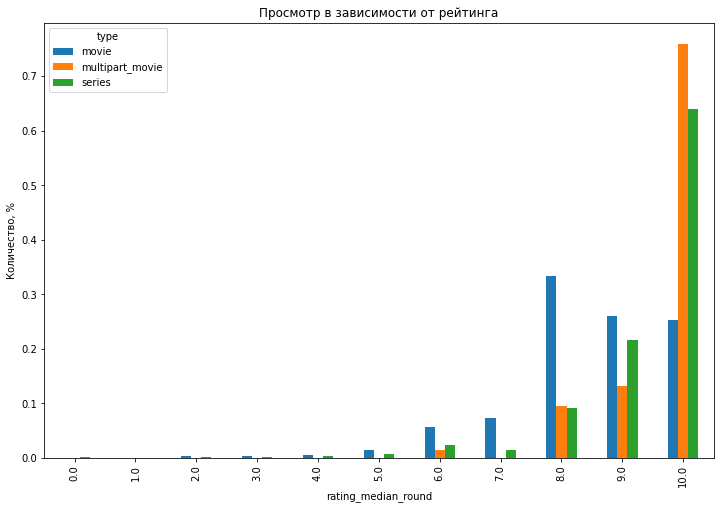

In [0]:
fig, ax = plt.subplots(figsize=(12, 8))
(transactions_ext.groupby('rating_median_round')['type']
                    .value_counts().unstack('type')
                    .apply(lambda x: x / x.sum())
                    .plot(kind='bar', ax=ax, title='Просмотр в зависимости от рейтинга'))
ax.set_ylabel('Количество, %');

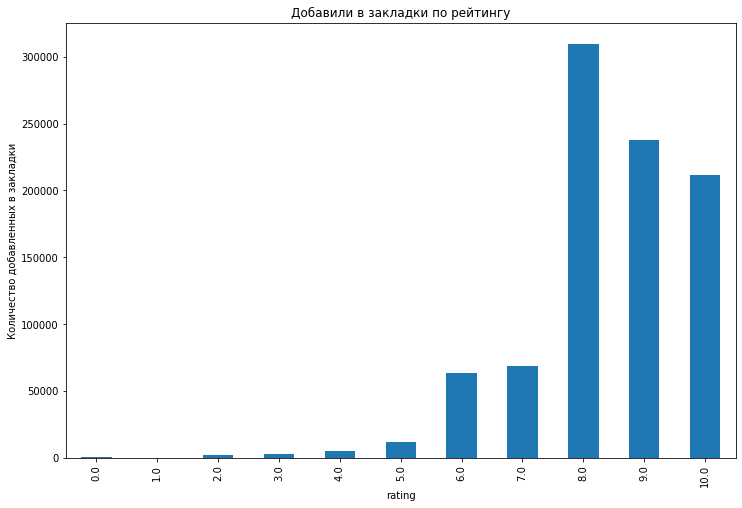

In [0]:
fig, ax = plt.subplots(figsize=(12, 8))
(catalogue.merge(bookmarks.groupby('element_uid').size().to_frame('cnt_bookmark').reset_index(), on='element_uid')
            .merge(ratings.groupby('element_uid')[['rating']].median().round().reset_index(), on='element_uid')
            .groupby('rating')['cnt_bookmark'].sum()
            .plot(kind='bar', title='Добавили в закладки по рейтингу')
)
ax.set_ylabel('Количество добавленных в закладки');

**Фильмы с рейтингом ниже 6 рекомендовать не будем**

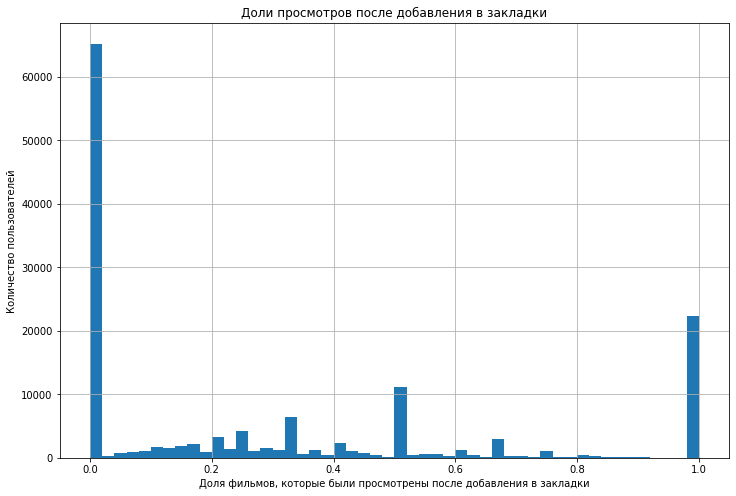

In [0]:
fig, ax = plt.subplots(figsize=(12, 8))

transactions['watched'] = 1
(transactions.merge(
                bookmarks, 
                on=['element_uid', 'user_uid'], 
                how='right', 
                suffixes=['_trans', '_bookmark'])
            .fillna(value={'ts_trans': 0, 'watched': 0})
            .query('ts_bookmark < ts_trans or ts_trans == 0')
            .groupby('user_uid')['watched'].mean()
            .hist(bins=50, ax=ax)
)
ax.set_title('Доли просмотров после добавления в закладки')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Доля фильмов, которые были просмотрены после добавления в закладки');

transactions.drop('watched', axis=1, inplace=True)

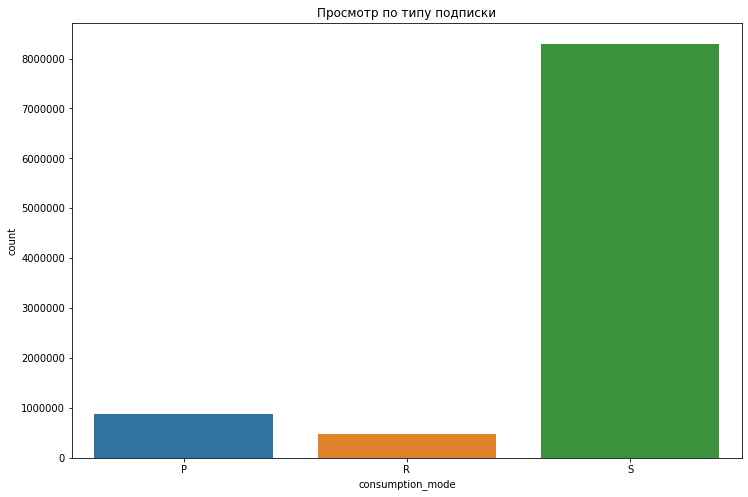

In [0]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='consumption_mode', data=transactions)
plt.title('Просмотр по типу подписки');

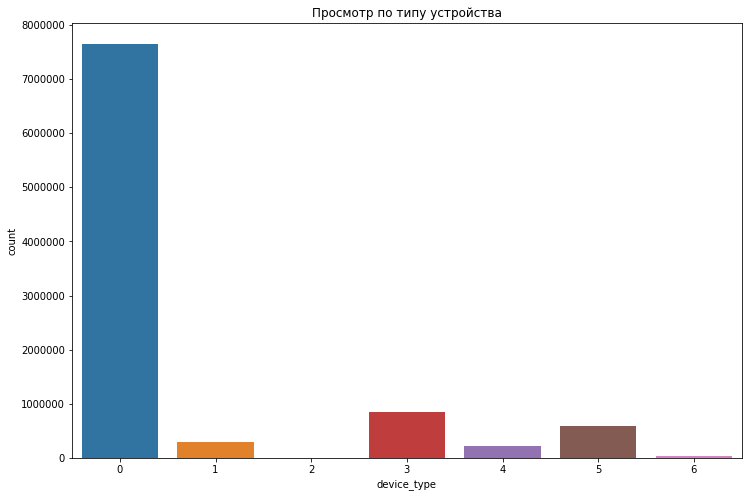

In [0]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='device_type', data=transactions)
plt.title('Просмотр по типу устройства');

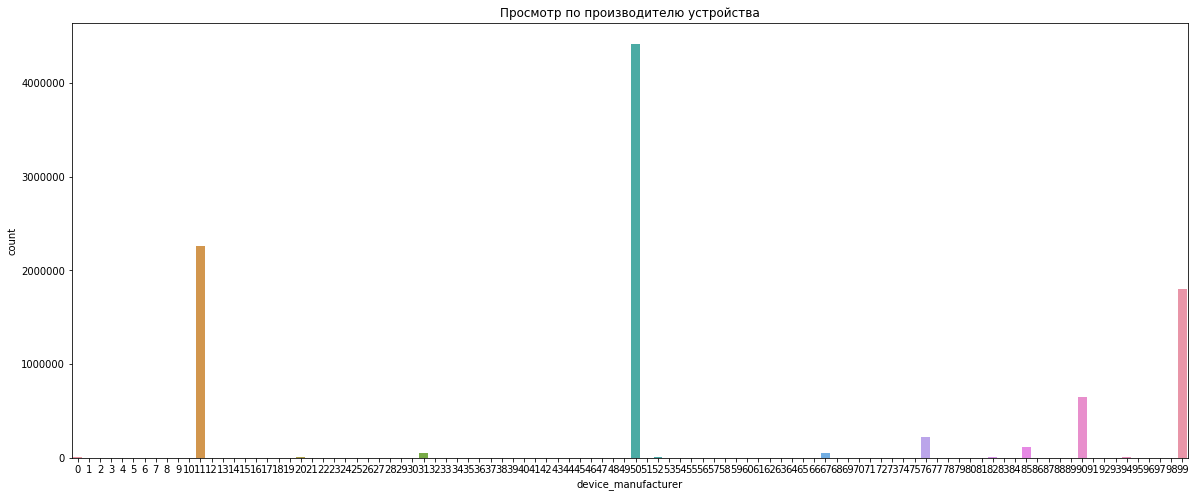

In [0]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(x='device_manufacturer', data=transactions)
plt.title('Просмотр по производителю устройства');

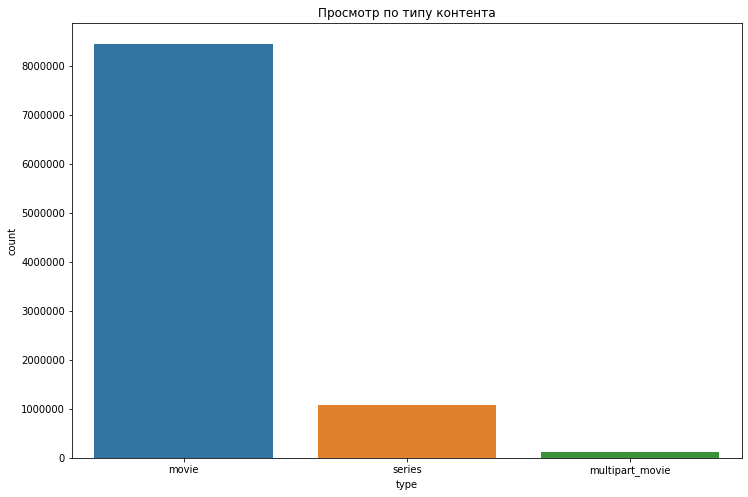

In [0]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x='type', data=transactions_ext)
plt.title('Просмотр по типу контента');

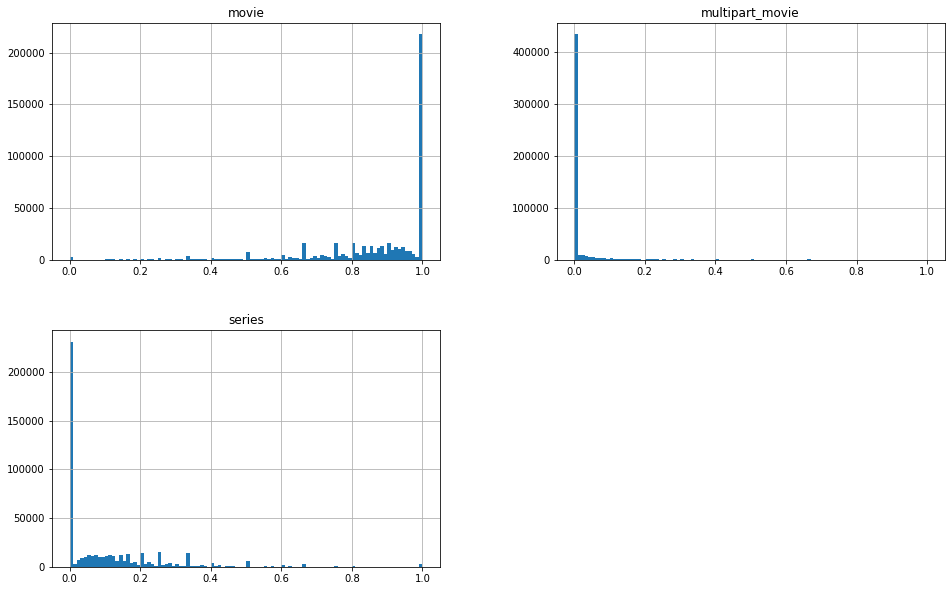

In [0]:
transactions_ext.groupby('user_uid')[['movie', 'multipart_movie', 'series']].mean().hist(figsize=(16, 10), bins=100);

Просмотров сериалов больше, чем фильмов. Это происходит потому что на просмотр сериала уходит значительно больше времени.
Можно рассматривать разные сценарии.

Для упрощения модели, можно делать рекомендации только на фильмы.
Отдельно построим модель для рекомендации сериалов.

In [0]:
# transactions_ext['watched_time_movie'] = transactions_ext['movie'] * transactions_ext['watched_time']
# transactions_ext['watched_time_series'] = transactions_ext['series'] * transactions_ext['watched_time']

# (transactions_ext.query('movie + series > 0')
#                 .groupby('user_uid')[['watched_time_movie', 'watched_time_series']].sum()
#                 .eval('watched_time_series / watched_time_movie')
#                 .replace([np.inf, np.nan])
#                 .fillna(1))#.hist(bins=100)

# (transactions_ext.query('type == "series"').groupby('user_uid')['watched_time'].sum() / 
# transactions_ext.query('type == "movie"').groupby('user_uid')['watched_time'].sum())#.fillna(1)

# Построение моделей

Функция для расчета метрики, код взят с https://habr.com/ru/company/okko/blog/439180/

In [0]:
%load_ext Cython

In [0]:
%%cython

def average_precision(
        dict data_true,
        dict data_predicted,
        const unsigned long int k
) -> float:
    cdef:
        unsigned long int n_items_predicted
        unsigned long int n_items_true
        unsigned long int n_correct_items
        unsigned long int item_idx

        double average_precision_sum
        double precision

        set items_true
        list items_predicted

    if not data_true:
        raise ValueError('data_true is empty')

    average_precision_sum = 0.0

    for key, items_true in data_true.items():
        items_predicted = data_predicted.get(key, [])

        n_items_true = len(items_true)
        n_items_predicted = min(len(items_predicted), k)

        if n_items_true == 0 or n_items_predicted == 0:
            continue

        n_correct_items = 0
        precision = 0.0

        for item_idx in range(n_items_predicted):
            if items_predicted[item_idx] in items_true:
                n_correct_items += 1
                precision += <double>n_correct_items / <double>(item_idx + 1)

        average_precision_sum += <double>precision / <double>min(n_items_true, k)

    return average_precision_sum / <double>len(data_true)

def metric(true_data, predicted_data, k=20):
    true_data_set = {k: set(v) for k, v in true_data.items()}

    return average_precision(true_data_set, predicted_data, k=k)

Функции для работы с данными

In [0]:
def split_data(transactions, ratings, bookmarks, test_size=0.3):
    '''функция разбивает данные на train и test'''

    ts_min = transactions['ts'].min()
    ts_max = transactions['ts'].max()
    ts_test = ts_min + (ts_max-ts_min) * (1-test_size)

    transactions_train = transactions.query('ts < @ts_test')
    transactions_test = transactions.query('ts >= @ts_test')

    ratings_train = ratings.query('ts < @ts_test')
    ratings_test = ratings.query('ts >= @ts_test')

    bookmarks_train = bookmarks.query('ts < @ts_test')
    bookmarks_test = bookmarks.query('ts >= @ts_test')

    return transactions_train, ratings_train, bookmarks_train, transactions_test, ratings_test, bookmarks_test

def add_attr_catalogue(catalogue, n_top=25):
    '''функция "разворачивает" атрибуты для фильмов'''

    catalogue_ext = catalogue.copy()
    counts_attributes = Counter(np.hstack(catalogue['attributes'].values))
    top_attributes = set(attribute for attribute, _ in counts_attributes.most_common(n_top))

    attributes_in_top = (catalogue['attributes'].apply(lambda x: pd.Series(list(top_attributes & set(x)))) # добавляем столбцы, где значения - атрибуты из топ
                                                .stack() # столбцы в индекс
                                                .astype(int)
                                                .to_frame('attribute')
                                                .reset_index()
                                                .set_index(['level_0', 'attribute']) # вместо индекс строки+индекс № бывш. столбца атрибута - индекс строки+значение атрибута
                                                .unstack('attribute')['level_1'] # из значение атрибута индекса в столбцы
                                                .applymap(lambda x: (x+1) / (x+1))) # если атрибут попадает в топ, то значение соотв. стобца = 1
    columns = list(map(lambda x: 'attribute_%s' % x, attributes_in_top.columns))
    attributes_in_top.columns = columns
    catalogue_ext[columns] = attributes_in_top
    catalogue_ext[columns] = catalogue_ext[columns].fillna(0).astype(np.uint8)

    availability = (catalogue_ext['availability'].apply(lambda x: pd.Series(x))
                                                .stack()
                                                .to_frame('availability')
                                                .reset_index()
                                                .set_index(['level_0', 'availability'])
                                                .unstack('availability')['level_1']
                                                .applymap(lambda x: (x+1) / (x+1)))                                   
    columns = list(map(lambda x: 'available_%s' % x, availability.columns))
    availability.columns = columns
    catalogue_ext[columns] = availability
    catalogue_ext[columns] = catalogue_ext[columns].fillna(0).astype(np.uint8)

    catalogue_ext.drop(['availability', 'attributes'], axis=1, inplace=True)

    return catalogue_ext

def get_poor_films(catalogue, transactions, ratings):
    '''Функция возвращает список "плохих" фильмов'''

    # с плохим рейтингом
    ratings_element = ratings.groupby('element_uid')['rating'].median().round().to_frame('rating_median').reset_index()
    poor_rating = ratings_element.query('rating_median < 5')['element_uid'].tolist()

    # с малым числом просмотров
    user_cnt = transactions['user_uid'].nunique()
    watched_cnt = transactions.groupby('element_uid').size().to_frame('cnt')
    watched_cnt['cnt_proc'] = 100 * watched_cnt['cnt'] / user_cnt
    poor_watched = watched_cnt[watched_cnt['cnt_proc'] < 0.1].index.to_list()

    # фильм никто никогда не смотрел
    no_watched = list(set(catalogue['element_uid']) - set(transactions['element_uid']))

    poor_films = set(poor_rating + poor_watched + no_watched)

    return poor_films

def union_data(transactions, catalogue, ratings, bookmarks):
    '''функция объединяет все данные'''

    # добавим к транзакциям инфу о самих объектах и рейтингах, закладках
    transactions_ext = (transactions.merge(catalogue, on=['element_uid'])
                                    .merge(ratings, on=['element_uid', 'user_uid'], how='left', suffixes=['', '_rating'])
                                    .merge(bookmarks, on=['element_uid', 'user_uid'], how='left', suffixes=['', '_bookmarks'])
                                    .fillna(value={'add_bookmark': 0})
                                    )
    #transactions_ext = transactions_ext.join(pd.get_dummies(transactions_ext[['type', 'consumption_mode']]))

    # добавим медианные рейтинги
    ratings_element = ratings.groupby('element_uid')['rating'].median().round().to_frame('rating_median').reset_index()
    transactions_ext = transactions_ext.merge(ratings_element, on='element_uid', how='left')

    # добавим общие длительности для каждого объекта
    real_duration = ((transactions_ext.groupby(['element_uid', 'type', 'duration'])['watched_time'].quantile(0.95) / 60)
                                        .to_frame('all_duration').reset_index())
    q = real_duration.eval('duration > 0 & type == "movie" & all_duration > duration')
    real_duration.loc[q, 'all_duration'] = real_duration['duration']
    q = real_duration.eval('duration > 0 & all_duration < duration')
    real_duration.loc[q, 'all_duration'] = real_duration['duration']
    real_duration['all_duration'] = real_duration['all_duration'] * 60

    transactions_ext = transactions_ext.merge(real_duration[['element_uid', 'all_duration']], on='element_uid')
    transactions_ext['watched_share'] = transactions_ext.eval('watched_time / all_duration').apply(lambda x: x if x <= 1 else 1)

    # сделаем признаки тип устройства и производитель категориальными
    transactions_ext[['device_type_cat', 'device_manufacturer_cat']] = transactions_ext[['device_type', 'device_manufacturer']].astype('category')

    return transactions_ext


def create_filtered_elements(df, users):
    '''
    функция возвращает словарь со списоком фильмов для каждого пользователя из датасета
    '''

    filtered_elements = defaultdict(set)

    for user_uid, element_uid in tqdm(df.loc[:, ['user_uid', 'element_uid']].values):
        if user_uid not in users:
            continue
        filtered_elements[user_uid].add(element_uid)
    return filtered_elements

def create_filtered_elements_all(films_in_transactions, films_in_ratings, users):

    filtered_elements = defaultdict(set)

    for user_uid in tqdm(users):
        filtered = []
        if user_uid in films_in_transactions:
            filtered += list(films_in_transactions[user_uid])

        if user_uid in films_in_ratings:
            filtered += list(films_in_ratings[user_uid])

        filtered_elements[user_uid] = set(filtered)

    return filtered_elements

def create_true_data(transactions, test_users):
    '''
    функция возвращает список фильмов которые пользователь посмотрел
    '''

    # Считается, что пользователь потребил контент, если он:
    # - Купил его или взял в аренду
    # - Посмотрел больше половины фильма по подписке
    # - Посмотрел больше трети сериала по подписке

    # transactions_ext = union_data(transactions, catalogue, ratings, bookmarks)
    # q1 = transactions_ext['consumption_mode'].isin(['P', 'R'])
    # q2 = (transactions_ext['type'].isin(['movie', 'multipart_movie'])) & (transactions_ext['watched_share'] > 0.5)
    # q3 = (transactions_ext['type'] == 'series') & (transactions_ext['watched_share'] > 1.0/3.0)
    # q4 = transactions_ext['user_uid'].isin(test_users)
    # true_data = transactions_ext[q1 | q2 | q3 | q4].copy()

    q = transactions['user_uid'].isin(test_users)
    true_data = transactions[q].copy()

    true_data['rank'] = true_data.groupby('user_uid')['ts'].rank('dense')
    true_data = (true_data.query('rank <= 20')
                        .sort_values(by=['user_uid', 'rank'])
                        .groupby('user_uid', sort=False)
                        .apply(lambda x: x['element_uid'].tolist())
                        .to_dict()
                )
    return true_data

Функции для LightFM

*   Документация по LightFM https://making.lyst.com/lightfm/docs/lightfm.html
*   Пример https://towardsdatascience.com/how-to-build-a-movie-recommender-system-in-python-using-lightfm-8fa49d7cbe3b
*   Пример https://www.kaggle.com/shivendra91/recommendation-lightfm
*   Пример https://www.machinelearningmastery.ru/solving-business-usecases-by-recommender-system-using-lightfm-4ba7b3ac8e62/

In [0]:
def create_interaction_matrix(user_uid_series, element_uid_series, rating_series, catalogue_ext):
    '''
    функция возвращает данные для обучения модели:
    - матрицу взаимодействия пользователей с контентом,
    - матрицу признаков контента
    - словари для перевода из кода категории в id 
    '''

    # построим матрицу, где: 
    # - строкам будут соответствовать пользователи 
    # - столбцам — элементы 
    # - на пересечении пользователя и элемента - количественная оценка степени их взаимодействия, если таковое имело место.

    user_uid = user_uid_series.astype('category')
    element_uid = element_uid_series.astype('category')

    ratings_matrix = sp.coo_matrix(
        (rating_series.astype(np.float32) + 1,
            (
                user_uid.cat.codes.copy(),
                element_uid.cat.codes.copy()
            )
        )
    )

    ratings_matrix = ratings_matrix.tocsr()

    # таблица признаков фильмов
    item_features = pd.DataFrame(
            StandardScaler().fit_transform(catalogue_ext.drop('element_uid', axis=1)), 
            index=catalogue_ext['element_uid'])\
        .loc[element_uid.unique()]\
        .values
    item_features = sp.csr_matrix(item_features)

    # словари для перевода из кода категории в id
    cat_to_user_uid = dict(zip(
        range(len(user_uid.cat.categories)),
        user_uid.cat.categories
    ))

    cat_to_element_uid = dict(zip(
        range(len(element_uid.cat.categories)),
        element_uid.cat.categories
    ))

    return ratings_matrix, item_features, cat_to_user_uid, cat_to_element_uid

def create_user_dict(model_lfm, test_users, cat_to_user_uid, cat_to_element_uid, item_features, 
                     filtered_elements, poor_films, top_pred=100):
    '''функция возвращает предсказания в виде словаря'''
    
    user_pred = dict()
    for user_id_cat, user_id in cat_to_user_uid.items():
        if user_id in test_users:
            scores = model_lfm.predict(
                user_ids=user_id_cat, 
                item_ids=np.arange(len(cat_to_element_uid)),
                item_features=item_features, 
                num_threads=4,
            )
            # user_pred[user_id] = [cat_to_element_uid[cod] for cod in np.argsort(-scores)[:top_pred]]

            elements_coded_ranked = np.argsort(-scores)
            elements_uid_ranked = []
            i = 0
            for cod in elements_coded_ranked:
                element_uid = cat_to_element_uid[cod]
                # рекомендованный фильм не в транзакциях, пользователь не проставил рейтинг, фильм не среди "плохих" фильмов
                if element_uid not in filtered_elements[user_id] and element_uid not in poor_films:
                    elements_uid_ranked.append(element_uid)
                    i += 1
                if i == top_pred:
                    break
            user_pred[user_id] = elements_uid_ranked
    
    return user_pred




def fit_model(model_lfm, model_name, start_epochs, max_epochs, step_epochs,
              ratings_matrix, item_features, cat_to_user_uid, cat_to_element_uid,  
              filtered_elements, poor_films, true_data, top_pred, results_path):
    '''
    функция обучает модель и сохраняет ее состояние на каждой итерации, кратно 5. Сохраняет результат.
    '''

    # получаем список пользователей, для которых нужно сделать пронозы
    users = set(true_data)

    # если файла с результатами испытаний нет, то создать его
    if not os.path.isfile(results_path):
        #print('ttt')
        pd.DataFrame(columns=LightFM().get_params().keys()).to_csv(results_path, index=False)

    # получаем параметры переданной модели
    current_result = pd.DataFrame({k: [v] for k, v in model_lfm.get_params().items()})

    # обучаем модель. После каждой итерации записываем результаты
    for i in tqdm(range(1, int(max_epochs/step_epochs) + 1)):
        model_lfm.fit_partial(
            interactions=ratings_matrix, 
            item_features=item_features, 
            epochs=step_epochs,
            num_threads=multiprocessing.cpu_count(),
            verbose=False
        )
        
        # считываем прошлые результаты
        all_results = pd.read_csv(results_path)

        # сохраняем модель
        n_model = all_results.shape[0] + 1

        if model_name is not None:
            model_path = os.path.join(
                DATA_PATH, 
                'models', 
                '{model_name}_{n_model}.pkl'.format(model_name=model_name, n_model=n_model))
            joblib.dump(model_lfm, model_path)

        # получаем результаты прогноза
        user_pred = create_user_dict(
            model_lfm, users, cat_to_user_uid, cat_to_element_uid, item_features, 
            filtered_elements, poor_films, top_pred=top_pred)

        # получаем скор
        score = metric(true_data, user_pred, k=20)

        # сколько всего эпох пройдено моделью
        all_epochs = step_epochs*i + start_epochs

        # сохраняем результаты
        current_result['use_item_features'] = int(item_features is not None)
        current_result['epochs'] = all_epochs
        current_result['score'] = score
        current_result['n_model'] = n_model
        pd.concat([all_results, current_result], sort=False).to_csv(results_path, index=False)

        print('all_epochs: {all_epochs}, score: {score}'.format(all_epochs=all_epochs, score=score))

def search_param_lfm(user_uid_series_train, element_uid_series_train, rating_series_train, catalogue_ext, 
                     transactions_test, users, filtered_elements_train, poor_films, use_item_features,
                     max_epochs, step_epochs, params, results_path):
    '''
    функция делает перебор параметров и сохраняет результаты
    '''

    # получаем необходимые данные для модели
    ratings_matrix, item_features, cat_to_user_uid, cat_to_element_uid = create_interaction_matrix(
        user_uid_series_train, 
        element_uid_series_train, 
        rating_series_train,
        catalogue_ext
    )

    # использовать или нет параметры фильмов в модели
    item_features = item_features if use_item_features else None

    # фактические просмотры
    true_data = create_true_data(transactions_test, users)

    for alpha, learning_rate, no_components, max_sampled, learning_schedule in tqdm(params):

        # создаем модель
        # при необходимости ее можно обучить, но тогда для start_epochs указать значение пройденных epochs
        model_lfm = LightFM(
            no_components=no_components, 
            learning_rate=learning_rate, 
            loss='warp', 
            max_sampled=max_sampled, 
            user_alpha=alpha, 
            item_alpha=alpha,
            learning_schedule=learning_schedule,
            random_state=42
        )

        # обучаем модель и получаем скор
        fit_model(
            model_lfm=model_lfm, 
            model_name=None, # если передать имя, то модели будут сохраняться
            start_epochs=0, 
            max_epochs=max_epochs, 
            step_epochs=step_epochs,
            ratings_matrix=ratings_matrix, 
            item_features=item_features, 
            cat_to_user_uid=cat_to_user_uid, 
            cat_to_element_uid=cat_to_element_uid,  
            filtered_elements=filtered_elements_train,
            poor_films=poor_films,
            true_data=true_data, 
            top_pred=20,
            results_path=results_path
        )

def create_user_dict_from_data_lfm(user_uid_series, element_uid_series, rating_series, catalogue_ext, 
                                   filtered_elements, poor_films, test_users, best_params, top_pred):
    '''
    построение прогнозов по данным при помощи light_fm
    '''

    # создаем модель
    model_lfm = LightFM(
        no_components=best_params['no_components'], 
        learning_rate=best_params['learning_rate'], 
        loss='warp', 
        max_sampled=best_params['max_sampled'], 
        user_alpha=best_params['user_alpha'], 
        item_alpha=best_params['item_alpha'],
        learning_schedule=best_params['learning_schedule'],
        random_state=42
    )

    # получаем необходимые данные для модели
    ratings_matrix, item_features, cat_to_user_uid, cat_to_element_uid = create_interaction_matrix(
        user_uid_series, 
        element_uid_series, 
        rating_series,
        catalogue_ext
    )
    item_features = item_features if best_params['use_item_features'] else None

    # обучаем модель
    model_lfm.fit(
        interactions=ratings_matrix, 
        item_features=item_features, 
        epochs=int(best_params['epochs']),
        num_threads=multiprocessing.cpu_count(),
        verbose=False
    )

    # получаем результаты прогноза
    user_pred = create_user_dict(
        model_lfm, test_users, cat_to_user_uid, cat_to_element_uid, item_features, 
        filtered_elements, poor_films, top_pred=top_pred
    )
    
    return user_pred

def merge_user_pred(user_pred_list, test_users, agg_func, top_pred=100):
    '''
    функция объединяет прогнозы разных моделей
    '''

    user_pred_merged = dict()
    for user_uid in test_users:
        # объединение всех прогнозов по всем источникам предсказаний для каждого пользователя
        all_elements = []
        for user_pred in user_pred_list:
            all_elements.append(pd.DataFrame(user_pred.get(user_uid, []), columns=['element_uid'])
                                .reset_index()
                                .set_index('element_uid')
            )

        # результирующий список топ фильмов для конкретного пользователя
        merged_elements = (pd.concat(all_elements, axis=1)
                                .fillna(0)
                                .agg(agg_func, axis=1)
                                .sort_values()
                                .index.tolist()[:top_pred]
        )

        user_pred_merged[user_uid] = merged_elements

    return user_pred_merged

def merge_user_pred_prior(user_pred_list, order, test_users):
    '''функция выбирает прогнозы в порядке очередности'''

    user_pred_merged = dict()
    for user_uid in test_users:
        for i in order:
            if user_uid in user_pred_list[i]:
                user_pred_merged[user_uid] = user_pred_list[i][user_uid]
                break
    return user_pred_merged

def create_merged_user_dict_lfm(ratings_train, bookmarks_train, watched_share_train, 
                                transactions_test, catalogue_ext,
                                file_params_rating, file_params_bookmarks, file_params_watched,
                                filtered_elements_train, test_users, top_pred):
    '''функция возвращает итоговый прогноз по трем омделям LightFM'''

    # по данным рейтинга
    # получение параметров
    all_params = pd.read_csv(file_params_rating)
    best_params = all_params.loc[all_params['score'].idxmax()]

    # получение прогнозов
    user_pred_ratings_lfm = create_user_dict_from_data_lfm(
        user_uid_series=ratings_train['user_uid'], 
        element_uid_series=ratings_train['element_uid'], 
        rating_series=ratings_train['rating'],
        catalogue_ext=catalogue_ext, 
        filtered_elements=filtered_elements_train, 
        poor_films=[], 
        test_users=test_users, 
        best_params=best_params, 
        top_pred=100)

    # по данным закладок
    # получение параметров
    all_params = pd.read_csv(file_params_bookmarks)
    best_params = all_params.loc[all_params['score'].idxmax()]

    # получение прогнозов
    user_pred_bookmarks_lfm = create_user_dict_from_data_lfm(
        user_uid_series=bookmarks_train['user_uid'], 
        element_uid_series=bookmarks_train['element_uid'], 
        rating_series=bookmarks_train['add_bookmark'], 
        catalogue_ext=catalogue_ext, 
        filtered_elements=filtered_elements_train, 
        poor_films=[], 
        test_users=test_users, 
        best_params=best_params, 
        top_pred=100)

    # по данным просмотров
    # получение параметров
    all_params = pd.read_csv(file_params_watched)
    best_params = all_params.loc[all_params['score'].idxmax()]

    # получение прогнозов
    user_pred_watched_lfm = create_user_dict_from_data_lfm(
        user_uid_series=watched_share_train['user_uid'], 
        element_uid_series=watched_share_train['element_uid'], 
        rating_series=watched_share_train['watched_share'], 
        catalogue_ext=catalogue_ext, 
        filtered_elements=filtered_elements_train, 
        poor_films=[], 
        test_users=test_users, 
        best_params=best_params, 
        top_pred=100)

    # if transactions_test is not None:

    # true_data = create_true_data(transactions_test, test_users)

    # order_list = list(permutations([0, 1, 2]))
    # score_list = []
    # user_pred_list=[user_pred_ratings_lfm, user_pred_bookmarks_lfm, user_pred_watched_lfm]
    # for order in order_list:
    #     user_pred_merged_prior = merge_user_pred_prior(
    #         user_pred_list=user_pred_list, 
    #         order=order,
    #         test_users=test_users
    #     )
    #     score = metric(true_data, user_pred_merged_prior, k=20)
    #     score_list.append(score)
    # best_i = np.argmax(score_list)

    user_pred_merged_lfm = merge_user_pred_prior(
        user_pred_list=[user_pred_ratings_lfm, user_pred_bookmarks_lfm, user_pred_watched_lfm], 
        order=[0, 1, 2],
        test_users=test_users
    )

    return user_pred_merged_lfm

Подготовка данных

In [0]:
# добавим к данным вспомогательные поля
bookmarks['add_bookmark'] = 1
transactions['watched_reality'] = 1

# разбиваем выборку на train/test
transactions_train, ratings_train, bookmarks_train, \
transactions_test, ratings_test, bookmarks_test = split_data(transactions, 
                                                             ratings, 
                                                             bookmarks, 
                                                             test_size=0.3)

transactions_train1, ratings_train1, bookmarks_train1, \
transactions_train2, ratings_train2, bookmarks_train2 = split_data(transactions_train, 
                                                                   ratings_train, 
                                                                   bookmarks_train, 
                                                                   test_size=0.3/0.7)


# объединяем данные о транзакциях с остальными
transactions_ext_train1 = union_data(transactions_train1, catalogue, ratings_train1, bookmarks_train1)
transactions_ext_train2 = union_data(transactions_train2, catalogue, ratings_train2, bookmarks_train1)
transactions_ext_train = union_data(transactions_train, catalogue, ratings_train, bookmarks_train)
transactions_ext_test = union_data(transactions_test, catalogue, ratings_test, bookmarks_test)
transactions_ext = union_data(transactions, catalogue, ratings, bookmarks)

# данные о доли времени просмотра каждого фильма по каждому пользователю
watched_share_train1 = transactions_ext_train1.groupby(['element_uid', 'user_uid'])[['watched_share']].mean().reset_index()
watched_share_train2 = transactions_ext_train2.groupby(['element_uid', 'user_uid'])[['watched_share']].mean().reset_index()
watched_share_train = transactions_ext_train.groupby(['element_uid', 'user_uid'])[['watched_share']].mean().reset_index()
watched_share_test = transactions_ext_test.groupby(['element_uid', 'user_uid'])[['watched_share']].mean().reset_index()
watched_share = transactions_ext.groupby(['element_uid', 'user_uid'])[['watched_share']].mean().reset_index()

# каталог фильмов с "распакованными" атрибутами
catalogue_ext = add_attr_catalogue(catalogue, n_top=25)
catalogue_ext = catalogue_ext.join(pd.get_dummies(catalogue_ext['type'])).drop('type', axis=1)

# получаем список "плохих" фильмов
poor_films = get_poor_films(catalogue, transactions, ratings)

# для каждого пользователя: наличие фильма в транзакциях, закладках, рейтинге
films_in_transactions_train1 = create_filtered_elements(transactions_train1, test_users)
films_in_ratings_train1 = create_filtered_elements(ratings_train1, test_users)
films_in_bookmarks_train1 = create_filtered_elements(bookmarks_train1, test_users)
filtered_elements_train1 = create_filtered_elements_all(films_in_transactions_train1, films_in_ratings_train1, test_users)

films_in_transactions_train = create_filtered_elements(transactions_train, test_users)
films_in_ratings_train = create_filtered_elements(ratings_train, test_users)
films_in_bookmarks_train = create_filtered_elements(bookmarks_train, test_users)
filtered_elements_train = create_filtered_elements_all(films_in_transactions_train, films_in_ratings_train, test_users)

films_in_transactions = create_filtered_elements(transactions, test_users)
films_in_ratings = create_filtered_elements(ratings, test_users)
films_in_bookmarks = create_filtered_elements(bookmarks, test_users)
filtered_elements = create_filtered_elements_all(films_in_transactions, films_in_ratings, test_users)

Построение моделей

Пользователи ведут себя по разному: одни ставят рейтинги, вторые пользуются закладками, третьи просто смотрят фильмы, а четвертые делают несколько вещей из перечисленных. Поэтому будем строить три модели и на вход подавать разные данные.   

Подбор параметров для LightFM

In [0]:
alpha_list = [0.001, 0.005] # 0.001
learning_rate_list = [0.01, 0.05] # 0.01
learning_schedule_list = ['adadelta'] # adagrad adadelta
no_components_list = [10, 100, 200]
max_sampled_list = [10, 100] # 10

params = list(product(alpha_list, learning_rate_list, no_components_list, max_sampled_list, learning_schedule_list))
len(params)

24

Модель по данным о рейтингах

In [0]:
%%time

search_param_lfm(
    user_uid_series_train=ratings_train['user_uid'], 
    element_uid_series_train=ratings_train['element_uid'], 
    rating_series_train=ratings_train['rating'], 
    catalogue_ext=catalogue_ext,
    transactions_test=transactions_test, 
    users=set(test_users) & set(ratings_train['user_uid']) & set(ratings_test['user_uid']), # пользователи встречаются train & test
    filtered_elements_train=filtered_elements_train, 
    poor_films=[], 
    use_item_features=False,
    max_epochs=40, 
    step_epochs=5, 
    params=params, 
    results_path=os.path.join(DATA_PATH, 'models', 'result_rating.csv')
)

In [0]:
result_rating = pd.read_csv(os.path.join(DATA_PATH, 'models', 'result_rating.csv'))
result_rating.sort_values(by='score', ascending=False).head(10)

,loss,learning_schedule,no_components,learning_rate,k,n,rho,epsilon,max_sampled,item_alpha,user_alpha,random_state,use_item_features,epochs,score,n_model
225,warp,adadelta,10,0.01,5,10,0.95,0.000001,10,0.005,0.005,RandomState(MT19937),0.0,35.0,0.023269,226.0
385,warp,adadelta,200,0.05,5,10,0.95,0.000001,10,0.005,0.005,RandomState(MT19937),0.0,35.0,0.022568,386.0
128,warp,adadelta,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,30.0,0.021246,129.0
78,warp,adadelta,100,0.01,5,10,0.95,0.000001,100,0.001,0.001,RandomState(MT19937),0.0,20.0,0.021170,79.0
120,warp,adagrad,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,30.0,0.021060,121.0
239,warp,adadelta,10,0.01,5,10,0.95,0.000001,100,0.005,0.005,RandomState(MT19937),0.0,25.0,0.021056,240.0
15,warp,adadelta,10,0.01,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,40.0,0.020973,16.0
121,warp,adagrad,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,35.0,0.020942,122.0
119,warp,adagrad,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,25.0,0.020937,120.0
122,warp,adagrad,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,40.0,0.020935,123.0


Модель по добавленным фильмам в закладки

In [0]:
%%time

search_param_lfm(
    user_uid_series_train=bookmarks_train['user_uid'], 
    element_uid_series_train=bookmarks_train['element_uid'], 
    rating_series_train=bookmarks_train['add_bookmark'], 
    catalogue_ext=catalogue_ext,
    transactions_test=transactions_test, 
    users=set(test_users) & set(bookmarks_train['user_uid']) & set(bookmarks_test['user_uid']), # пользователи встречаются train & test
    filtered_elements_train=filtered_elements_train, 
    poor_films=[], 
    use_item_features=False,
    max_epochs=40, 
    step_epochs=5, 
    params=params[13:], 
    results_path=os.path.join(DATA_PATH, 'models', 'result_bookmarks.csv')
)

In [0]:
result_bookmarks = pd.read_csv(os.path.join(DATA_PATH, 'models', 'result_bookmarks.csv'))
result_bookmarks.sort_values(by='score', ascending=False).head(10)

,loss,learning_schedule,no_components,learning_rate,k,n,rho,epsilon,max_sampled,item_alpha,user_alpha,random_state,use_item_features,epochs,score,n_model
51,warp,adadelta,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,20.0,0.025828,52.0
55,warp,adadelta,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,40.0,0.025758,56.0
240,warp,adadelta,10,0.05,5,10,0.95,0.000001,100,0.005,0.005,RandomState(MT19937),0.0,5.0,0.022511,241.0
33,warp,adadelta,200,0.01,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,10.0,0.021342,34.0
210,warp,adadelta,100,0.01,5,10,0.95,0.000001,100,0.005,0.005,RandomState(MT19937),0.0,15.0,0.020062,211.0
62,warp,adadelta,10,0.05,5,10,0.95,0.000001,100,0.001,0.001,RandomState(MT19937),0.0,35.0,0.020045,63.0
208,warp,adadelta,100,0.01,5,10,0.95,0.000001,100,0.005,0.005,RandomState(MT19937),0.0,5.0,0.018943,209.0
38,warp,adadelta,200,0.01,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,35.0,0.018730,39.0
74,warp,adadelta,100,0.05,5,10,0.95,0.000001,100,0.001,0.001,RandomState(MT19937),0.0,15.0,0.018518,75.0
168,warp,adadelta,100,0.05,5,10,0.95,0.000001,100,0.005,0.005,RandomState(MT19937),0.0,5.0,0.018421,169.0


Модель по данным о доли времени просмотренных фильмов

In [0]:
%%time

search_param_lfm(
    user_uid_series_train=watched_share_train['user_uid'], 
    element_uid_series_train=watched_share_train['element_uid'], 
    rating_series_train=watched_share_train['watched_share'], 
    catalogue_ext=catalogue_ext,
    transactions_test=transactions_test, 
    users=set(test_users) & set(watched_share_train['user_uid']) & set(watched_share_test['user_uid']), # пользователи встречаются train & test
    filtered_elements_train=filtered_elements_train, 
    poor_films=[], 
    use_item_features=False,
    max_epochs=40, 
    step_epochs=5, 
    params=params, 
    results_path=os.path.join(DATA_PATH, 'models', 'result_watched.csv')
)

In [0]:
result_watched = pd.read_csv(os.path.join(DATA_PATH, 'models', 'result_watched.csv'))
result_watched.sort_values(by='score', ascending=False).head(10)

,loss,learning_schedule,no_components,learning_rate,k,n,rho,epsilon,max_sampled,item_alpha,user_alpha,random_state,use_item_features,epochs,score,n_model
1,warp,adadelta,10,0.01,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,10.0,0.016264,2.0
6,warp,adadelta,10,0.01,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,35.0,0.015582,7.0
52,warp,adadelta,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,25.0,0.015537,53.0
7,warp,adadelta,10,0.01,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,40.0,0.014828,8.0
100,warp,adadelta,10,0.01,5,10,0.95,0.000001,10,0.005,0.005,RandomState(MT19937),0.0,25.0,0.014669,101.0
55,warp,adadelta,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,40.0,0.014004,56.0
61,warp,adadelta,10,0.05,5,10,0.95,0.000001,100,0.001,0.001,RandomState(MT19937),0.0,30.0,0.013982,62.0
54,warp,adadelta,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,35.0,0.013682,55.0
53,warp,adadelta,10,0.05,5,10,0.95,0.000001,10,0.001,0.001,RandomState(MT19937),0.0,30.0,0.013577,54.0
96,warp,adadelta,10,0.01,5,10,0.95,0.000001,10,0.005,0.005,RandomState(MT19937),0.0,5.0,0.013559,97.0


Получение прогнозов от LightFM

In [0]:
%%time

user_pred_merged_lfm_train1 = create_merged_user_dict_lfm(
    ratings_train=ratings_train1, 
    bookmarks_train=bookmarks_train1, 
    watched_share_train=watched_share_train1, 
    transactions_test=transactions_train2, 
    catalogue_ext=catalogue_ext,
    file_params_rating=os.path.join(DATA_PATH, 'models', 'result_rating.csv'), 
    file_params_bookmarks=os.path.join(DATA_PATH, 'models', 'result_bookmarks.csv'), 
    file_params_watched=os.path.join(DATA_PATH, 'models', 'result_watched.csv'),
    filtered_elements_train=filtered_elements_train1, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_lfm_train1, os.path.join(DATA_PATH, 'models', 'user_pred_merged_lfm_train1.pkl'))

CPU times: user 7min 38s, sys: 2.06 s, total: 7min 40s
Wall time: 2min 6s


In [0]:
%%time

user_pred_merged_lfm_train = create_merged_user_dict_lfm(
    ratings_train=ratings_train, 
    bookmarks_train=bookmarks_train, 
    watched_share_train=watched_share_train, 
    transactions_test=transactions_test, 
    catalogue_ext=catalogue_ext,
    file_params_rating=os.path.join(DATA_PATH, 'models', 'result_rating.csv'), 
    file_params_bookmarks=os.path.join(DATA_PATH, 'models', 'result_bookmarks.csv'), 
    file_params_watched=os.path.join(DATA_PATH, 'models', 'result_watched.csv'),
    filtered_elements_train=filtered_elements_train, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_lfm_train, os.path.join(DATA_PATH, 'models', 'user_pred_merged_lfm_train.pkl'))

CPU times: user 12min 20s, sys: 3.57 s, total: 12min 24s
Wall time: 3min 18s


In [0]:
%%time

user_pred_merged_lfm = create_merged_user_dict_lfm(
    ratings_train=ratings, 
    bookmarks_train=bookmarks, 
    watched_share_train=watched_share, 
    transactions_test=None, 
    catalogue_ext=catalogue_ext,
    file_params_rating=os.path.join(DATA_PATH, 'models', 'result_rating.csv'), 
    file_params_bookmarks=os.path.join(DATA_PATH, 'models', 'result_bookmarks.csv'), 
    file_params_watched=os.path.join(DATA_PATH, 'models', 'result_watched.csv'),
    filtered_elements_train=filtered_elements, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_lfm, os.path.join(DATA_PATH, 'models', 'user_pred_merged_lfm.pkl'))

CPU times: user 16min 55s, sys: 4.54 s, total: 17min
Wall time: 4min 33s


Подбор параметров для B25

In [0]:
def create_user_dict_from_data_TFIDF(model, user_uid_series, element_uid_series, rating_series, 
                                     filtered_elements, poor_films, users, top_pred=20):
    '''Получение прогнозов от модели TFIDF'''

    # подготовка данных для модели
    user_uid = user_uid_series.astype('category')
    element_uid = element_uid_series.astype('category')

    ratings_matrix = sp.coo_matrix(
        (rating_series.astype(np.float32) + 1,
            (
                element_uid.cat.codes.copy(),
                user_uid.cat.codes.copy()
            )
        )
    )
    ratings_matrix = ratings_matrix.tocsr()

    # обучение модели
    #model_TFIDF = TFIDFRecommender(K=K)
    model.fit(ratings_matrix)

    # подготовка данных для прогноза
    ratings_matrix_T = ratings_matrix.T.tocsr()

    user_uid_to_cat = dict(zip(
        user_uid.cat.categories,
        range(len(user_uid.cat.categories))
    ))

    element_uid_to_cat = dict(zip(
        element_uid.cat.categories,
        range(len(element_uid.cat.categories))
    ))

    filtered_elements_cat = {k: [element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

    # построение прогноза
    result = {}

    for user_uid in users:
        # transform user_uid to model's internal user category
        try:
            user_cat = user_uid_to_cat[user_uid]
        except LookupError:
            continue
        
        # perform inference
        recs = model.recommend(
            user_cat,
            ratings_matrix_T,
            N=top_pred,
            filter_already_liked_items=True,
            filter_items=set(filtered_elements_cat.get(user_uid, set())) | set(poor_films)
        )
        
        # drop scores and transform model's internal elelemnt category to element_uid for every prediction
        # also convert np.uint64 to int so it could be json serialized later
        result[user_uid] = [int(element_uid.cat.categories[i]) for i, _ in recs]

    return result

def create_merged_user_dict_TFIDF(ratings, bookmarks, watched_share,
                                  model_ratings, model_bookmarks, model_watched,
                                  filtered_elements, test_users, top_pred):

    user_pred_rating = create_user_dict_from_data_TFIDF(
        model_ratings,
        ratings['user_uid'], 
        ratings['element_uid'], 
        ratings['rating'], 
        filtered_elements, 
        [],
        test_users,
        top_pred
    )

    user_pred_bookmarks = create_user_dict_from_data_TFIDF(
        model_bookmarks,
        bookmarks['user_uid'], 
        bookmarks['element_uid'], 
        bookmarks['add_bookmark'], 
        filtered_elements, 
        [],
        test_users,
        top_pred
    )

    user_pred_watched = create_user_dict_from_data_TFIDF(
        model_watched,
        watched_share['user_uid'], 
        watched_share['element_uid'], 
        watched_share['watched_share'], 
        filtered_elements, 
        [],
        test_users,
        top_pred
    )

    user_pred_merged = merge_user_pred_prior(
        user_pred_list=[user_pred_watched, user_pred_rating, user_pred_bookmarks], 
        order=[0, 1, 2],
        test_users=test_users
    )

    return user_pred_merged

In [0]:
K_list = np.arange(50, 500, 50)
B_list = np.arange(0.1, 1, 0.2)
params = list(product(K_list, B_list))

In [0]:
%%time

result = pd.DataFrame(params, columns=['K', 'B'])

for index, rec in tqdm(result.iterrows(), total=result.shape[0]):
    K = int(rec['K'])
    B = rec['B']

    users = set(test_users) & set(ratings_train['user_uid']) & set(ratings_test['user_uid'])
    user_pred = create_user_dict_from_data_TFIDF(
        #TFIDFRecommender(K=K),
        BM25Recommender(K=K, B=B),
        ratings_train['user_uid'], 
        ratings_train['element_uid'], 
        ratings_train['rating'], 
        filtered_elements_train, 
        [],
        users,
    )
    true_data = create_true_data(transactions_test, users)
    result.loc[index, 'score'] = metric(true_data, user_pred, k=20)

result.sort_values(by='score', ascending=False).head(10)

In [0]:
result.sort_values(by='score', ascending=False).head(10)

,K,B,score
26,300,0.3,0.020211
36,400,0.3,0.020210
21,250,0.3,0.020210
31,350,0.3,0.020197
41,450,0.3,0.020189
16,200,0.3,0.020141
6,100,0.3,0.020102
1,50,0.3,0.019957
15,200,0.1,0.019931
10,150,0.1,0.019930


In [0]:
K_list = np.arange(50, 500, 50)
B_list = np.arange(0.1, 1, 0.2)
params = list(product(K_list, B_list))

In [0]:
%%time

result = pd.DataFrame(params, columns=['K', 'B'])
for index, rec in tqdm(result.iterrows(), total=result.shape[0]):
    K = int(rec['K'])
    B = rec['B']

    users = set(test_users) & set(bookmarks_train['user_uid']) & set(bookmarks_test['user_uid'])
    user_pred = create_user_dict_from_data_TFIDF(
        BM25Recommender(K=K, B=B),
        bookmarks_train['user_uid'], 
        bookmarks_train['element_uid'], 
        bookmarks_train['add_bookmark'], 
        filtered_elements_train, 
        [],
        users,
    )
    true_data = create_true_data(transactions_test, users)
    result.loc[index, 'score'] = metric(true_data, user_pred, k=20)

In [0]:
result.sort_values(by='score', ascending=False).head(10)

,K,B,score
40,450,0.1,0.012928
30,350,0.1,0.012927
35,400,0.1,0.012927
25,300,0.1,0.012915
20,250,0.1,0.012794
15,200,0.1,0.012775
5,100,0.1,0.012738
10,150,0.1,0.012719
0,50,0.1,0.012243
31,350,0.3,0.011077


In [0]:
K_list = np.arange(50, 500, 50)
B_list = np.arange(0.1, 1, 0.2)
params = list(product(K_list, B_list))

In [0]:
%%time

result = pd.DataFrame(params, columns=['K', 'B'])
for index, rec in tqdm(result.iterrows(), total=result.shape[0]):
    K = int(rec['K'])
    B = rec['B']

    users = set(test_users) & set(watched_share_train['user_uid']) & set(watched_share_test['user_uid'])
    user_pred = create_user_dict_from_data_TFIDF(
        BM25Recommender(K=K, B=B),
        watched_share_train['user_uid'], 
        watched_share_train['element_uid'], 
        watched_share_train['watched_share'], 
        filtered_elements_train, 
        [],
        users,
    )
    true_data = create_true_data(transactions_test, users)
    result.loc[index, 'score'] = metric(true_data, user_pred, k=20)

In [0]:
result.sort_values(by='score', ascending=False).head(10)

,K,B,score
41,450,0.3,0.024168
31,350,0.3,0.024148
36,400,0.3,0.024141
16,200,0.3,0.024135
26,300,0.3,0.024100
21,250,0.3,0.024068
11,150,0.3,0.024002
40,450,0.1,0.023977
6,100,0.3,0.023972
35,400,0.1,0.023968


Построение прогнозов

In [0]:
%%time

user_pred_merged_B25_train1 = create_merged_user_dict_TFIDF(
    ratings=ratings_train1, 
    bookmarks=bookmarks_train1, 
    watched_share=watched_share_train1,
    model_ratings=BM25Recommender(K=300, B=0.3), 
    model_bookmarks=BM25Recommender(K=450, B=0.1), 
    model_watched=BM25Recommender(K=450, B=0.3),
    filtered_elements=filtered_elements_train1, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_B25_train1, os.path.join(DATA_PATH, 'models', 'user_pred_merged_B25_train1.pkl'))


CPU times: user 53.1 s, sys: 521 ms, total: 53.6 s
Wall time: 51.5 s


In [0]:
%%time

user_pred_merged_B25_train = create_merged_user_dict_TFIDF(
    ratings=ratings_train, 
    bookmarks=bookmarks_train, 
    watched_share=watched_share_train,
    model_ratings=BM25Recommender(K=300, B=0.3), 
    model_bookmarks=BM25Recommender(K=450, B=0.1), 
    model_watched=BM25Recommender(K=450, B=0.3),
    filtered_elements=filtered_elements_train, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_B25_train, os.path.join(DATA_PATH, 'models', 'user_pred_merged_B25_train.pkl'))


CPU times: user 1min 15s, sys: 704 ms, total: 1min 15s
Wall time: 1min 11s


In [0]:
%%time

user_pred_merged_B25 = create_merged_user_dict_TFIDF(
    ratings=ratings, 
    bookmarks=bookmarks, 
    watched_share=watched_share,
    model_ratings=BM25Recommender(K=300, B=0.3), 
    model_bookmarks=BM25Recommender(K=450, B=0.1), 
    model_watched=BM25Recommender(K=450, B=0.3),
    filtered_elements=filtered_elements, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_B25, os.path.join(DATA_PATH, 'models', 'user_pred_merged_B25.pkl'))


CPU times: user 1min 39s, sys: 1.03 s, total: 1min 40s
Wall time: 1min 33s


Подбор параметров для TFIDF

In [0]:
K_list = np.arange(50, 500, 50)

In [0]:
%%time

result = pd.DataFrame(K_list, columns=['K'])

for index, rec in tqdm(result.iterrows(), total=result.shape[0]):
    K = int(rec['K'])

    users = set(test_users) & set(ratings_train['user_uid']) & set(ratings_test['user_uid'])
    user_pred = create_user_dict_from_data_TFIDF(
        TFIDFRecommender(K=K),
        ratings_train['user_uid'], 
        ratings_train['element_uid'], 
        ratings_train['rating'], 
        filtered_elements_train, 
        [],
        users,
    )
    true_data = create_true_data(transactions_test, users)
    result.loc[index, 'score'] = metric(true_data, user_pred, k=20)

result.sort_values(by='score', ascending=False).head(10)

In [0]:
result.sort_values(by='score', ascending=False).head(10)

,K,score
8,450,0.015075
7,400,0.015051
4,250,0.014999
6,350,0.014980
5,300,0.014931
3,200,0.014873
2,150,0.014770
1,100,0.014399
0,50,0.013537


In [0]:
%%time

result = pd.DataFrame(K_list, columns=['K'])

for index, rec in tqdm(result.iterrows(), total=result.shape[0]):
    K = int(rec['K'])

    users = set(test_users) & set(bookmarks_train['user_uid']) & set(bookmarks_test['user_uid'])
    user_pred = create_user_dict_from_data_TFIDF(
        TFIDFRecommender(K=K),
        bookmarks_train['user_uid'], 
        bookmarks_train['element_uid'], 
        bookmarks_train['add_bookmark'], 
        filtered_elements_train, 
        [],
        users,
    )
    true_data = create_true_data(transactions_test, users)
    result.loc[index, 'score'] = metric(true_data, user_pred, k=20)

result.sort_values(by='score', ascending=False).head(10)

In [0]:
result.sort_values(by='score', ascending=False).head(10)

,K,score
6,350,0.010375
8,450,0.010312
5,300,0.010305
4,250,0.010235
7,400,0.010212
3,200,0.010092
2,150,0.010091
1,100,0.009921
0,50,0.009683


In [0]:
%%time

result = pd.DataFrame(K_list, columns=['K'])

for index, rec in tqdm(result.iterrows(), total=result.shape[0]):
    K = int(rec['K'])

    users = set(test_users) & set(watched_share_train['user_uid']) & set(watched_share_test['user_uid'])
    user_pred = create_user_dict_from_data_TFIDF(
        TFIDFRecommender(K=K),
        watched_share_train['user_uid'], 
        watched_share_train['element_uid'], 
        watched_share_train['watched_share'], 
        filtered_elements_train, 
        [],
        users,
    )
    true_data = create_true_data(transactions_test, users)
    result.loc[index, 'score'] = metric(true_data, user_pred, k=20)

result.sort_values(by='score', ascending=False).head(10)

In [0]:
result.sort_values(by='score', ascending=False).head(10)

,K,score
6,350,0.024112
7,400,0.024093
8,450,0.024077
5,300,0.024036
3,200,0.023990
4,250,0.023953
2,150,0.023815
0,50,0.023781
1,100,0.023727


Построение прогнозов

In [0]:
%%time

user_pred_merged_TFIDF_train1 = create_merged_user_dict_TFIDF(
    ratings=ratings_train1, 
    bookmarks=bookmarks_train1, 
    watched_share=watched_share_train1,
    model_ratings=TFIDFRecommender(K=450), 
    model_bookmarks=TFIDFRecommender(K=350), 
    model_watched=TFIDFRecommender(K=350),
    filtered_elements=filtered_elements_train1, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_TFIDF_train1, os.path.join(DATA_PATH, 'models', 'user_pred_merged_TFIDF_train1.pkl'))


CPU times: user 53.3 s, sys: 470 ms, total: 53.8 s
Wall time: 51.8 s


In [0]:
%%time

user_pred_merged_TFIDF_train = create_merged_user_dict_TFIDF(
    ratings=ratings_train, 
    bookmarks=bookmarks_train, 
    watched_share=watched_share_train,
    model_ratings=TFIDFRecommender(K=450), 
    model_bookmarks=TFIDFRecommender(K=350), 
    model_watched=TFIDFRecommender(K=350),
    filtered_elements=filtered_elements_train, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_TFIDF_train, os.path.join(DATA_PATH, 'models', 'user_pred_merged_TFIDF_train.pkl'))


CPU times: user 1min 15s, sys: 779 ms, total: 1min 16s
Wall time: 1min 12s


In [0]:
%%time

user_pred_merged_TFIDF = create_merged_user_dict_TFIDF(
    ratings=ratings, 
    bookmarks=bookmarks, 
    watched_share=watched_share,
    model_ratings=TFIDFRecommender(K=450), 
    model_bookmarks=TFIDFRecommender(K=350), 
    model_watched=TFIDFRecommender(K=350),
    filtered_elements=filtered_elements, 
    test_users=test_users, 
    top_pred=200
)
joblib.dump(user_pred_merged_TFIDF, os.path.join(DATA_PATH, 'models', 'user_pred_merged_TFIDF.pkl'))


CPU times: user 1min 38s, sys: 1.03 s, total: 1min 39s
Wall time: 1min 33s


Получение сохраненных прогнозов со всех моделей 1 уровня

In [0]:
%%time

user_pred_merged_lfm_train1 = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_lfm_train1.pkl'))
user_pred_merged_lfm_train = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_lfm_train.pkl'))
user_pred_merged_lfm = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_lfm.pkl'))

CPU times: user 12.3 s, sys: 549 ms, total: 12.9 s
Wall time: 12.9 s


In [0]:
%%time

user_pred_merged_B25_train1 = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_B25_train1.pkl'))
user_pred_merged_B25_train = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_B25_train.pkl'))
user_pred_merged_B25 = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_B25.pkl'))

CPU times: user 22.1 s, sys: 1.21 s, total: 23.3 s
Wall time: 23.3 s


In [0]:
%%time

user_pred_merged_TFIDF_train1 = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_TFIDF_train1.pkl'))
user_pred_merged_TFIDF_train = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_TFIDF_train.pkl'))
user_pred_merged_TFIDF = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_merged_TFIDF.pkl'))

CPU times: user 24 s, sys: 1.2 s, total: 25.2 s
Wall time: 25.2 s


In [0]:
%%time

user_pred_merged_sum_lfm_B25_train = merge_user_pred(
    user_pred_list=[user_pred_merged_lfm_train, user_pred_merged_B25_train], 
    test_users=test_users, 
    agg_func=np.sum,
    top_pred=100
)

user_pred_merged_mean_lfm_B25_train = merge_user_pred(
    user_pred_list=[user_pred_merged_lfm_train, user_pred_merged_B25_train], 
    test_users=test_users, 
    agg_func=np.mean,
    top_pred=100
)

user_pred_merged_sum_lfm_B25_TFIDF_train = merge_user_pred(
    user_pred_list=[user_pred_merged_lfm_train, user_pred_merged_B25_train, user_pred_merged_TFIDF_train], 
    test_users=test_users, 
    agg_func=np.sum,
    top_pred=100
)

user_pred_merged_mean_lfm_B25_TFIDF_train = merge_user_pred(
    user_pred_list=[user_pred_merged_lfm_train, user_pred_merged_B25_train, user_pred_merged_TFIDF_train], 
    test_users=test_users, 
    agg_func=np.mean,
    top_pred=100
)

CPU times: user 25min 15s, sys: 3.27 s, total: 25min 19s
Wall time: 25min 20s


In [0]:
%%time

user_pred_merged_sum_B25_TFIDF_train = merge_user_pred(
    user_pred_list=[user_pred_merged_B25_train, user_pred_merged_TFIDF_train], 
    test_users=test_users, 
    agg_func=np.sum,
    top_pred=100
)

user_pred_merged_mean_B25_TFIDF_train = merge_user_pred(
    user_pred_list=[user_pred_merged_B25_train, user_pred_merged_TFIDF_train], 
    test_users=test_users, 
    agg_func=np.mean,
    top_pred=100
)

CPU times: user 10min 35s, sys: 1.58 s, total: 10min 37s
Wall time: 10min 37s


In [0]:
%%time

true_data = create_true_data(transactions_test, test_users)

score_lfm = metric(true_data, user_pred_merged_lfm_train, k=20)
score_B25 = metric(true_data, user_pred_merged_B25_train, k=20)
score_TFIDF = metric(true_data, user_pred_merged_TFIDF_train, k=20)

score_lfm_B25_sum = metric(true_data, user_pred_merged_sum_lfm_B25_train, k=20)
score_lfm_B25_mean = metric(true_data, user_pred_merged_mean_lfm_B25_train, k=20)

score_B25_TFIDF_sum = metric(true_data, user_pred_merged_sum_B25_TFIDF_train, k=20)
score_B25_TFIDF_mean = metric(true_data, user_pred_merged_mean_B25_TFIDF_train, k=20)

score_lfm_B25_TFIDF_sum = metric(true_data, user_pred_merged_sum_lfm_B25_TFIDF_train, k=20)
score_lfm_B25_TFIDF_mean = metric(true_data, user_pred_merged_mean_lfm_B25_TFIDF_train, k=20)

CPU times: user 19 s, sys: 195 ms, total: 19.2 s
Wall time: 19.2 s


In [0]:
print('score_lfm:', score_lfm)
print('score_B25', score_B25)
print('score_TFIDF', score_TFIDF)
print()
print('score_lfm_B25_sum', score_lfm_B25_sum)
print('score_lfm_B25_mean', score_lfm_B25_mean)
print()
print('score_B25_TFIDF_sum', score_B25_TFIDF_sum)
print('score_B25_TFIDF_mean', score_B25_TFIDF_mean)
print()
print('score_lfm_B25_TFIDF_sum', score_lfm_B25_TFIDF_sum)
print('score_lfm_B25_TFIDF_mean', score_lfm_B25_TFIDF_mean)

score_lfm: 0.0096542468871209
score_B25 0.018955117662205156
score_TFIDF 0.018890730071554247

score_lfm_B25_sum 0.016199855095761648
score_lfm_B25_mean 0.016199855095761648

score_B25_TFIDF_sum 0.019352291209488146
score_B25_TFIDF_mean 0.019352291209488146

score_lfm_B25_TFIDF_sum 0.01452673848322284
score_lfm_B25_TFIDF_mean 0.01452673848322284


In [0]:
%%time

user_pred_model1_train1 = merge_user_pred(
    user_pred_list=[user_pred_merged_B25_train1, user_pred_merged_TFIDF_train1], 
    test_users=test_users, 
    agg_func=np.mean,
    top_pred=100
)
joblib.dump(user_pred_model1_train1, os.path.join(DATA_PATH, 'models', 'user_pred_model1_train1.pkl'))

CPU times: user 5min 47s, sys: 752 ms, total: 5min 48s
Wall time: 5min 48s


In [0]:
%%time

user_pred_model1_train = merge_user_pred(
    user_pred_list=[user_pred_merged_B25_train, user_pred_merged_TFIDF_train], 
    test_users=test_users, 
    agg_func=np.mean,
    top_pred=100
)
joblib.dump(user_pred_model1_train, os.path.join(DATA_PATH, 'models', 'user_pred_model1_train.pkl'))

CPU times: user 5min 19s, sys: 714 ms, total: 5min 19s
Wall time: 5min 20s


In [0]:
%%time

user_pred_model1 = merge_user_pred(
    user_pred_list=[user_pred_merged_B25, user_pred_merged_TFIDF], 
    test_users=test_users, 
    agg_func=np.mean,
    top_pred=100
)
joblib.dump(user_pred_model1, os.path.join(DATA_PATH, 'models', 'user_pred_model1.pkl'))

CPU times: user 4min 54s, sys: 641 ms, total: 4min 54s
Wall time: 4min 54s


In [0]:
%%time

user_pred_model1_train1 = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_model1_train1.pkl'))
user_pred_model1_train = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_model1_train.pkl'))
user_pred_model1 = joblib.load(os.path.join(DATA_PATH, 'models', 'user_pred_model1.pkl'))

CPU times: user 11.9 s, sys: 220 ms, total: 12.1 s
Wall time: 12.1 s


Получение прогнозов от модели 2 уровня

In [0]:
def create_df(transactions, catalogue, ratings, bookmarks, test_users, user_pred_model1, transactions_test):
    '''построение признаков для бустинга'''

    transactions_ext = union_data(transactions, catalogue, ratings, bookmarks)
    catalogue_ext = add_attr_catalogue(catalogue, n_top=25)
    catalogue_ext = catalogue_ext.join(pd.get_dummies(catalogue_ext['type'])).drop('type', axis=1)

    # признаки фильмов
    agg_funcs = {
        'add_bookmark': np.sum, 
        'watched_reality': np.sum, 
        'all_duration': lambda x: round(np.max(x) / 60), 
        'rating_median': np.max,
        'watched_share': np.mean, 
        'device_type_cat': lambda x: stats.mode(x)[0][0], 
        'device_manufacturer_cat':lambda x: stats.mode(x)[0][0],
    }
    columns = list(agg_funcs.keys())
    elements_transactions = (
        transactions_ext
            .groupby('element_uid')[columns]
            .agg(agg_funcs)
            .fillna({'rating_median': 6})
            .reset_index()
            .rename(columns={'watched_reality': 'watched_cnt'})
    )

    active_users_cnt = (
        transactions_ext
            .groupby('user_uid')
            .size()
            .to_frame('cnt')
            .query('cnt > 10')
            .shape[0]
    )
    elements_transactions['watched_cnt'] = elements_transactions['watched_cnt'] / active_users_cnt

    columns = [
        'element_uid', 
        'feature_1',
        'feature_2',
        'feature_3',
        'feature_4',
        'feature_5',
        'available_purchase',
        'available_rent',
        'available_subscription',
        'movie',
        'multipart_movie',
        'series'
    ]
    elements_transactions = elements_transactions.merge(catalogue_ext[columns], on='element_uid')

    # признаки пользователей

    users = set(test_users) & set(transactions_ext['user_uid'])
    df_users = pd.DataFrame(index=users)
    df_users.index.name = 'user_uid'

    # продолжительность пользования сайтом
    df_users['durations_ts'] = (
        transactions_ext
            .query('user_uid in @users')
            .groupby('user_uid')['ts']
            .agg(['min', 'max'])
            .rename(columns={'min': 'min_ts', 'max': 'max_ts'})
            .eval('(max_ts - min_ts) / 100')
            .round()
    )

    # среднее время просмотра, средняя доля времени просморов, частый дейвайс, частый производитель
    agg_funcs = {
        'watched_time': 'mean', 
        'watched_share': 'mean', 
        'device_type_cat': lambda x: stats.mode(x)[0][0], 
        'device_manufacturer_cat': lambda x: stats.mode(x)[0][0]
    }
    columns = list(agg_funcs.keys())
    df_users[columns] = (
        transactions_ext
            .query('user_uid in @users')
            .groupby('user_uid')[columns]
            .agg(agg_funcs)
    )

    # доли просмотров каждого вида контента, вида подписки
    share_type_movie_consumption_mode = pd.get_dummies(
        transactions_ext
            .query('user_uid in @users')
            .set_index('user_uid')[['type', 'consumption_mode']]
    ).groupby('user_uid').mean()
    df_users[share_type_movie_consumption_mode.columns] = share_type_movie_consumption_mode

    # какие рейтинги ставит пользователь фильму
    rating_cnt = (
        ratings
            .query('user_uid in @users')
            .groupby('user_uid')['rating']
            .value_counts()
            .to_frame('cnt')
            .unstack('rating')['cnt']
            .fillna(0)
    )
    rating_cnt = rating_cnt.div(rating_cnt.sum(axis=1), axis=0)
    columns = list(map(lambda x: 'rating_%s' % x, rating_cnt.columns))
    df_users[columns] = rating_cnt
    df_users[columns] = df_users[columns].fillna(df_users[columns].mean())

    # доля просмотренных фильмов после добавления в закладки
    df_users['bookmark_share'] = (
        transactions
            .merge(
                bookmarks, 
                on=['element_uid', 'user_uid'], 
                how='right', 
                suffixes=['_trans', '_bookmark'])
            .fillna(value={'ts_trans': 0, 'watched_reality': 0})
            .query('ts_bookmark < ts_trans or ts_trans == 0')
            .groupby('user_uid')['watched_reality'].mean()
    )
    df_users.fillna(value={'bookmark_share': 0}, inplace=True)

    df_users.reset_index(inplace=True)

    # обработка прогнозов
    user_pred_df = (
        pd.Series(user_pred_model1).apply(lambda x: pd.Series(x))
        .stack()
        .to_frame('element_uid')
        .reset_index()
        .rename(columns={
            'level_0': 'user_uid', 
            'level_1': 'rank'
            })
    )

    # добавляем признак смотрел/не смотрел
    user_pred_df = user_pred_df.merge(
        transactions_test[['user_uid', 'element_uid', 'watched_reality']],
        on=['user_uid', 'element_uid'],
        how='left'
    ).fillna(value={'watched_reality': 0})

    # объединение данных
    df_modif = (
        user_pred_df
            .merge(
                df_users,
                on='user_uid',
                suffixes=['', '_user']
            ).merge(
                elements_transactions,
                on='element_uid',
                suffixes=['_user', '_film']
            )
    )

    # врядли эти признаки помогут
    columns = [
        'device_type_cat_user',
        'device_manufacturer_cat_user',
        'device_type_cat_film',
        'device_manufacturer_cat_film'
    ]
    df_modif.drop(columns, axis=1, inplace=True)

    df_modif.sort_values(['user_uid', 'rank'], inplace=True)
    df_modif.set_index(['user_uid', 'element_uid'], inplace=True)

    return df_modif

In [0]:
def lgbm_fit(df_modif_train, verbose=False):
    X_train = df_modif_train.drop('watched_reality', axis=1).values
    y_train = df_modif_train['watched_reality'].values
    q_train = df_modif_train.reset_index().groupby('user_uid', sort=False).size().values

    gbm = lgb.LGBMRanker()
    gbm.fit(
        X_train, 
        y_train, 
        group=q_train, 
        eval_set=[(X_train, y_train)],
        eval_group=[q_train], 
        early_stopping_rounds=100, 
        verbose=verbose,
        eval_metric='ndcg'
    )
    del X_train
    del y_train

    return gbm

def create_user_dict_lgb(gbm, df_modif):

    user_pred_lgbm_df = df_modif.reset_index()
    user_pred_lgbm_df['rank'] = gbm.predict(df_modif.drop('watched_reality', axis=1).values)
    user_pred_lgbm = (
        user_pred_lgbm_df
            .sort_values(['user_uid', 'rank'], ascending=[True, False])
            .groupby('user_uid', sort=False)
            .apply(lambda x: x['element_uid'].tolist())
            .to_dict()
    )

    other_users = list(set(test_users) - set(user_pred_lgbm_df['user_uid']))
    top_films = user_pred_lgbm_df.groupby('element_uid')['rank'].sum().sort_values(ascending=False).index.tolist()[:20]

    for user_uid in other_users:
        user_pred_lgbm[user_uid] = top_films

    del user_pred_lgbm_df

    return user_pred_lgbm

In [0]:
%%time

df_modif_train1 = create_df(
    transactions_train, catalogue, ratings_train, 
    bookmarks_train, test_users, user_pred_model1_train1, transactions_train2
)

CPU times: user 1min 51s, sys: 1.67 s, total: 1min 53s
Wall time: 1min 53s


In [0]:
%%time

df_modif_train = create_df(
    transactions, catalogue, ratings, 
    bookmarks, test_users, user_pred_model1_train, transactions_test
)

CPU times: user 2min 17s, sys: 2.89 s, total: 2min 20s
Wall time: 2min 20s


In [0]:
df_modif_train.head()

rank  watched_reality  ...  multipart_movie  series
user_uid element_uid                         ...                         
0        3757.0          0              0.0  ...                0       0
         2245.0          1              1.0  ...                0       0
         283.0           2              0.0  ...                0       0
         8152.0          3              0.0  ...                0       0
         10061.0         4              0.0  ...                0       0

[5 rows x 39 columns]

In [0]:
true_data = create_true_data(transactions_test, test_users)

In [0]:
%%time

gbm = lgbm_fit(df_modif_train1)
user_pred_lgbm = create_user_dict_lgb(gbm, df_modif_train)

CPU times: user 6min 30s, sys: 7.15 s, total: 6min 38s
Wall time: 2min 3s


In [0]:
score_lgbm = metric(true_data, user_pred_lgbm, k=20)
score_lgbm

0.02619730166303457

In [0]:
score_lfm = metric(true_data, user_pred_model1_train, k=20)
score_lfm

0.019352291209488146

Финал

In [0]:
%%time

df_modif = create_df(
    transactions, catalogue, ratings, 
    bookmarks, test_users, user_pred_model1, transactions_test
)

gbm = lgbm_fit(df_modif_train)
user_pred_lgbm = create_user_dict_lgb(gbm, df_modif)

with open('answer_lgbm.json', 'w') as f:
    json.dump(user_pred_lgbm, f)

CPU times: user 10min 28s, sys: 8.04 s, total: 10min 36s
Wall time: 4min 54s


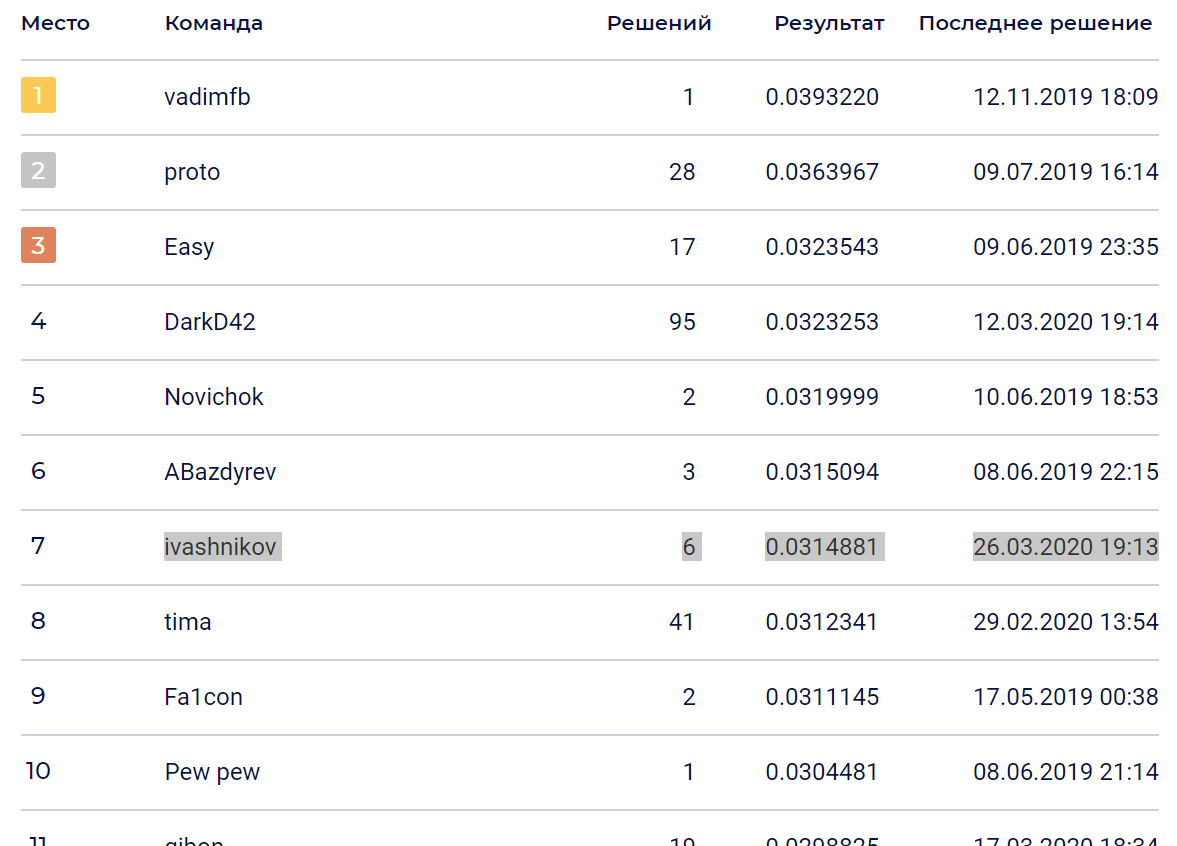